In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import skimage
import random
import os
from scipy import ndimage
import imutils
import math
%matplotlib inline

In [2]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [3]:
def find_parent(parent, i):
    if(parent[i]==  i):
        return i
    return find_parent(parent, parent[i])

In [4]:
def shrink_array(cntsarray):
    finalcnts= []
    sumarray= (np.sum(np.sum(np.sum(cntsarray, axis= 1), axis= 1), axis= 1))
    print (sumarray)
    parent= np.arange(len(sumarray))
    print (parent)
    for i in range(len(sumarray)):
        for j in range(len(sumarray)):
            if(i!= j and abs(sumarray[i]-sumarray[j])<= 10):
                a= find_parent(parent, i)
                b= find_parent(parent, j)
                parent[b]= a
    for i in range(len(parent)):
        if(parent[i]== i):
            finalcnts.append(cntsarray[i])
    return finalcnts

In [5]:
def flattener(image, pts, w, h):
    temp_rect = np.zeros((4,2), dtype = "float32")
    
    s = np.sum(pts, axis = 2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    # Need to create an array listing points in order of
    # [top left, top right, bottom right, bottom left]
    # before doing the perspective transform

    if w <= 0.8*h: # If card is vertically oriented
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.2*h: # If card is horizontally oriented
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    # If the card is 'diamond' oriented, a different algorithm
    # has to be used to identify which point is top left, top right
    # bottom left, and bottom right.
    
    if w > 0.8*h and w < 1.2*h: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0] # Top left
            temp_rect[1] = pts[0][0] # Top right
            temp_rect[2] = pts[3][0] # Bottom right
            temp_rect[3] = pts[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if pts[1][0][1] > pts[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0] # Top left
            temp_rect[1] = pts[3][0] # Top right
            temp_rect[2] = pts[2][0] # Bottom right
            temp_rect[3] = pts[1][0] # Bottom left
            
        
    maxWidth = 200
    maxHeight = 300
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp


In [6]:
def get_rank(imarray, cnt):
    card= cnt
    x,y,w,h= cv2.boundingRect(card)
    warp1= flattener(imarray, card, w, h)[6:45, 5:34]
#     print (warp1.shape)
    plt.imshow(warp1)
    plt.show()
    return warp1

In [7]:
def get_suit(imarray, cnt):
    card= cnt
    x,y,w,h= cv2.boundingRect(card)
    warp1= flattener(imarray, card, w, h)[44:77, 5:34]
#     print (warp1.shape)
    plt.imshow(warp1)
    plt.show()
    return warp1

In [8]:
def card_detect(loc):
    imarray= np.array(cv2.imread(loc, 0))
    print (imarray.shape)
    imblur1= cv2.GaussianBlur(imarray, (5,5), 0)
    imblur2= cv2.GaussianBlur(imarray, (7,7), 0)
    plt.imshow(imblur1, cmap= 'gray')
    plt.title("After Gaussian Blur")
    plt.show()
    
    high_thresh, thresh_im = cv2.threshold(imblur1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    edgearray1= cv2.Canny(imblur1, low_thresh, high_thresh)
    high_thresh, thresh_im = cv2.threshold(imblur2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    edgearray2= cv2.Canny(imblur2, low_thresh, high_thresh)
    plt.imshow(edgearray1, cmap= 'gray')
    plt.title("After Edge detection")
    plt.show()
    cnts1= cv2.findContours(edgearray1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts1= imutils.grab_contours(cnts1)
    cnts2= cv2.findContours(edgearray2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts2= imutils.grab_contours(cnts2)
    cnts1.extend(cnts2)
    cnts= sorted(cnts1, key = cv2.contourArea, reverse = True)[:15]
    print (len(cnts))
    
    cntsarray= []
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.009*peri, True)
        if len(approx) == 4:#card will be a rectangle always
            cntsarray.append(approx)
            
    imarraycolor= np.array(cv2.imread(loc))
    print (len(cntsarray))
    cv2.drawContours(imarraycolor, cntsarray, -1, (0, 255, 0), 3)
    plt.imshow(imarraycolor)
    plt.title("Contours detected")
    plt.show()
    cv2.imwrite('./op.png', imarraycolor)
    sumarray= (np.sum(np.sum(np.sum(cntsarray, axis= 1), axis= 1), axis= 1))
    return shrink_array(cntsarray)

In [13]:
def rankplussuit_detect(imarray, cntsarray):
    for cnt in cntsarray:
        obsrank= get_rank(imarray, cnt)
        obssuit= get_suit(imarray, cnt)
        rankPath= './templates/ranks/'
        suitPath= './templates/suits/'
        ssesuits= []
        sseranks= []
        for fold in os.listdir(rankPath):
            summ= 0
            for img in os.listdir(os.path.join(rankPath, fold)):
                fullname= os.path.join(os.path.join(rankPath, fold), img)
                rank= np.array(cv2.imread(fullname, 0))
                minx= min(rank.shape[0], obsrank.shape[0])
                miny= min(rank.shape[1], obsrank.shape[1])
                obsrankres= cv2.resize(obsrank, (miny, minx))
                rankres= cv2.resize(rank, (miny, minx))
                summ+= np.sum(np.abs(rankres - obsrankres)**2)
            sseranks.append(summ)
        print (sseranks)
        print ("The rank of the card is: " + os.listdir(rankPath)[np.argmin(sseranks)])
        
        for fold in os.listdir(suitPath):
            summ= 0
            for img in os.listdir(os.path.join(suitPath, fold)):
                fullname= os.path.join(os.path.join(suitPath, fold), img)
                suit= np.array(cv2.imread(fullname, 0))
                minx= min(suit.shape[0], obssuit.shape[0])
                miny= min(suit.shape[1], obssuit.shape[1])
                obssuitres= cv2.resize(obssuit, (miny, minx))
                suitres= cv2.resize(suit, (miny, minx))
                summ+= np.sum(np.abs(suitres - obssuitres)**2)
            ssesuits.append(summ)
        print (ssesuits)
        print ("The suit of the card is: " + os.listdir(suitPath)[np.argmin(ssesuits)])
    

(749, 700)


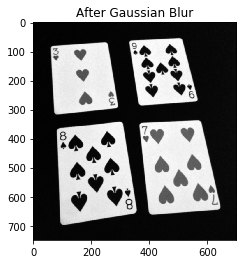

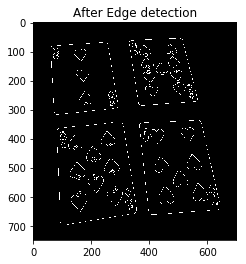

15
15


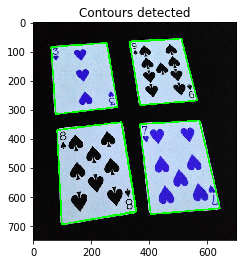

[2897 2897 2899 2897 3969 3969 3969 3969 1446 1446 1446 1446 2448 2448
 2448]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
4


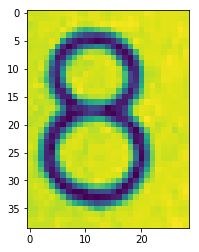

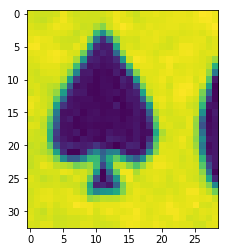

[2091341.0, 1819125.0, 2135948.0, 1944376.0, 2566731.0, 2172117.0, 2662594.0, 2268787.0, 1751953.0, 1842784.0, 2142591.0]
The rank of the card is: 8
[1718880.0, 1914043.0, 2153587.0, 1854435.0]
The suit of the card is: Hearts


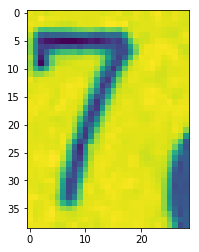

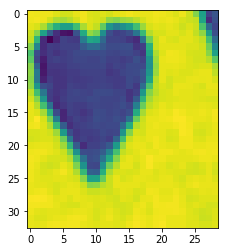

[2137693.0, 2094167.0, 2324932.0, 2515562.0, 2818281.0, 2238839.0, 1911658.0, 1901901.0, 2025277.0, 1706414.0, 1638185.0]
The rank of the card is: 3
[1833074.0, 1877397.0, 1590805.0, 2186425.0]
The suit of the card is: Spades


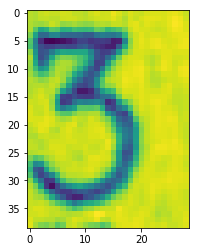

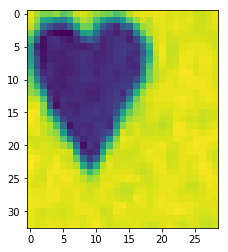

[2160355.0, 2001965.0, 2323660.0, 2192554.0, 2747473.0, 2252131.0, 2403782.0, 2239725.0, 1872959.0, 1790312.0, 2034709.0]
The rank of the card is: 9
[1951782.0, 1921589.0, 1858573.0, 2299417.0]
The suit of the card is: Spades


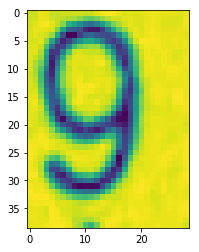

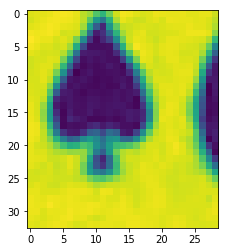

[2103223.0, 2077609.0, 2299656.0, 2412866.0, 2739141.0, 2162669.0, 2172156.0, 1962715.0, 1970457.0, 1733108.0, 1859431.0]
The rank of the card is: 9
[1840816.0, 1908081.0, 1695319.0, 2270315.0]
The suit of the card is: Spades


In [21]:
imarray= np.array(cv2.imread('./im4.jpeg', 0))
cntsarray= card_detect('./im4.jpeg')
print (len(cntsarray))
rankplussuit_detect(imarray, cntsarray)

In [18]:
os.listdir('./templates/ranks/')

['2', '5', '7', 'A', '10', '6', 'Q', '4', '8', '9', '3']